# Use Better Seg Mask

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
---- Initializing Dataset ---- 
	 N_samples: 921600
	 Split: test2
	 Train: False
	 transforms: None
There are [23] objects in total
[['35' 'jenga']
 ['39' 'master_chef_can']
 ['48' 'potted_meat_can']
 ['51' 'pudding_box']
 ['58' 'wood_block']] Scene: 1-1-10


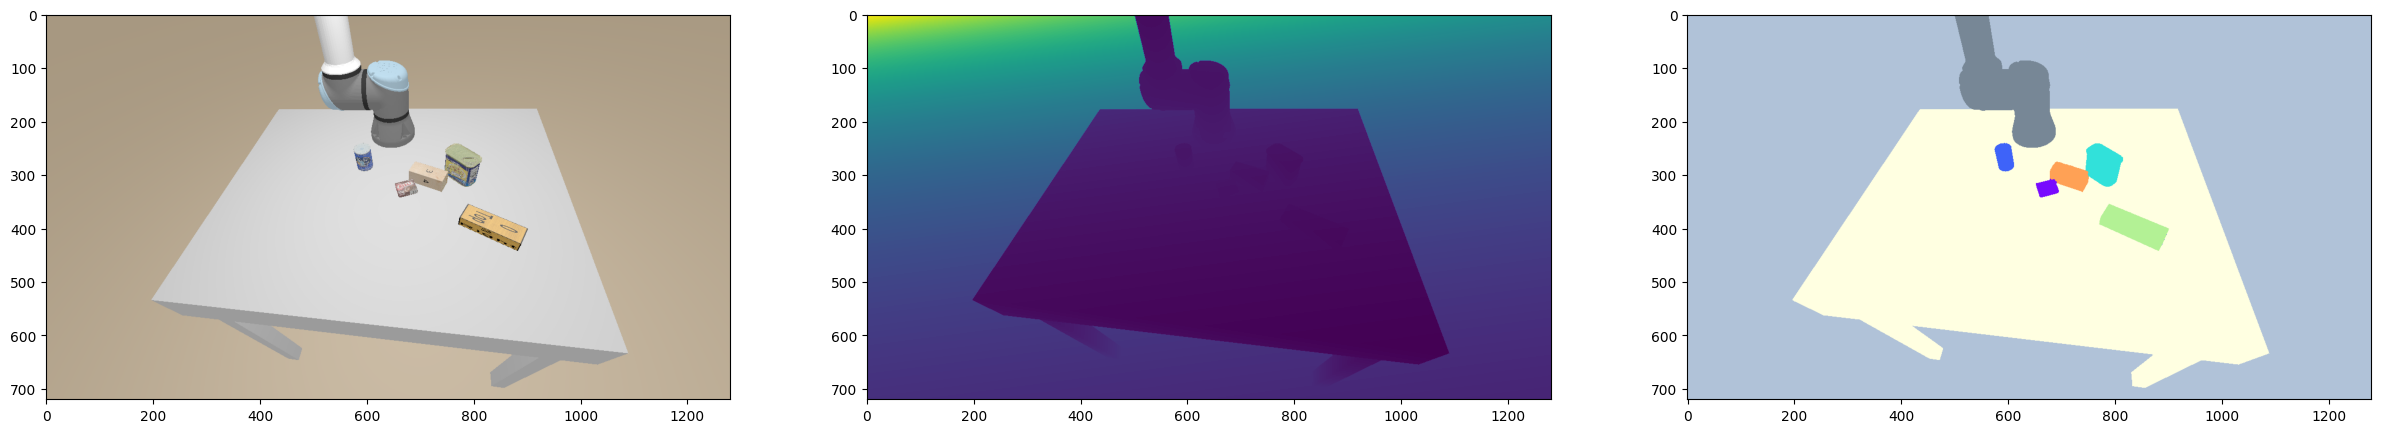

In [1]:
from utils.utils_data import *


params = {'bz': 1, 'shuffle': False, 'num_workers':1}


loader = get_loader(SegDataset(split_name='test2', transforms=None, train=False), params)


''' Sample 1 batch from dataset, and visualize '''
sample = next(iter(loader))
rgb    = sample['rgb']        # (B,3,H,W)
label  = sample['label']      # (B,1,H,W)
depth  = sample['depth']      # (B,1,H,W)
meta   = sample['meta']       # List (B,)
meta = load_pickle(meta[0])
suffix = sample['suffix']     # List (B,)
suffix = suffix[0]


depth = depth.squeeze(0).permute(1,2,0).detach().numpy()
rgb   = rgb.squeeze(0).permute(1,2,0).detach().numpy()
label = label.squeeze().detach().numpy()
visualize_one_scene(rgb, depth, label, meta, suffix)

  0%|          | 1/400 [00:23<2:36:43, 23.57s/it]


[['35' 'jenga']
 ['39' 'master_chef_can']
 ['48' 'potted_meat_can']
 ['51' 'pudding_box']
 ['58' 'wood_block']] Scene: None


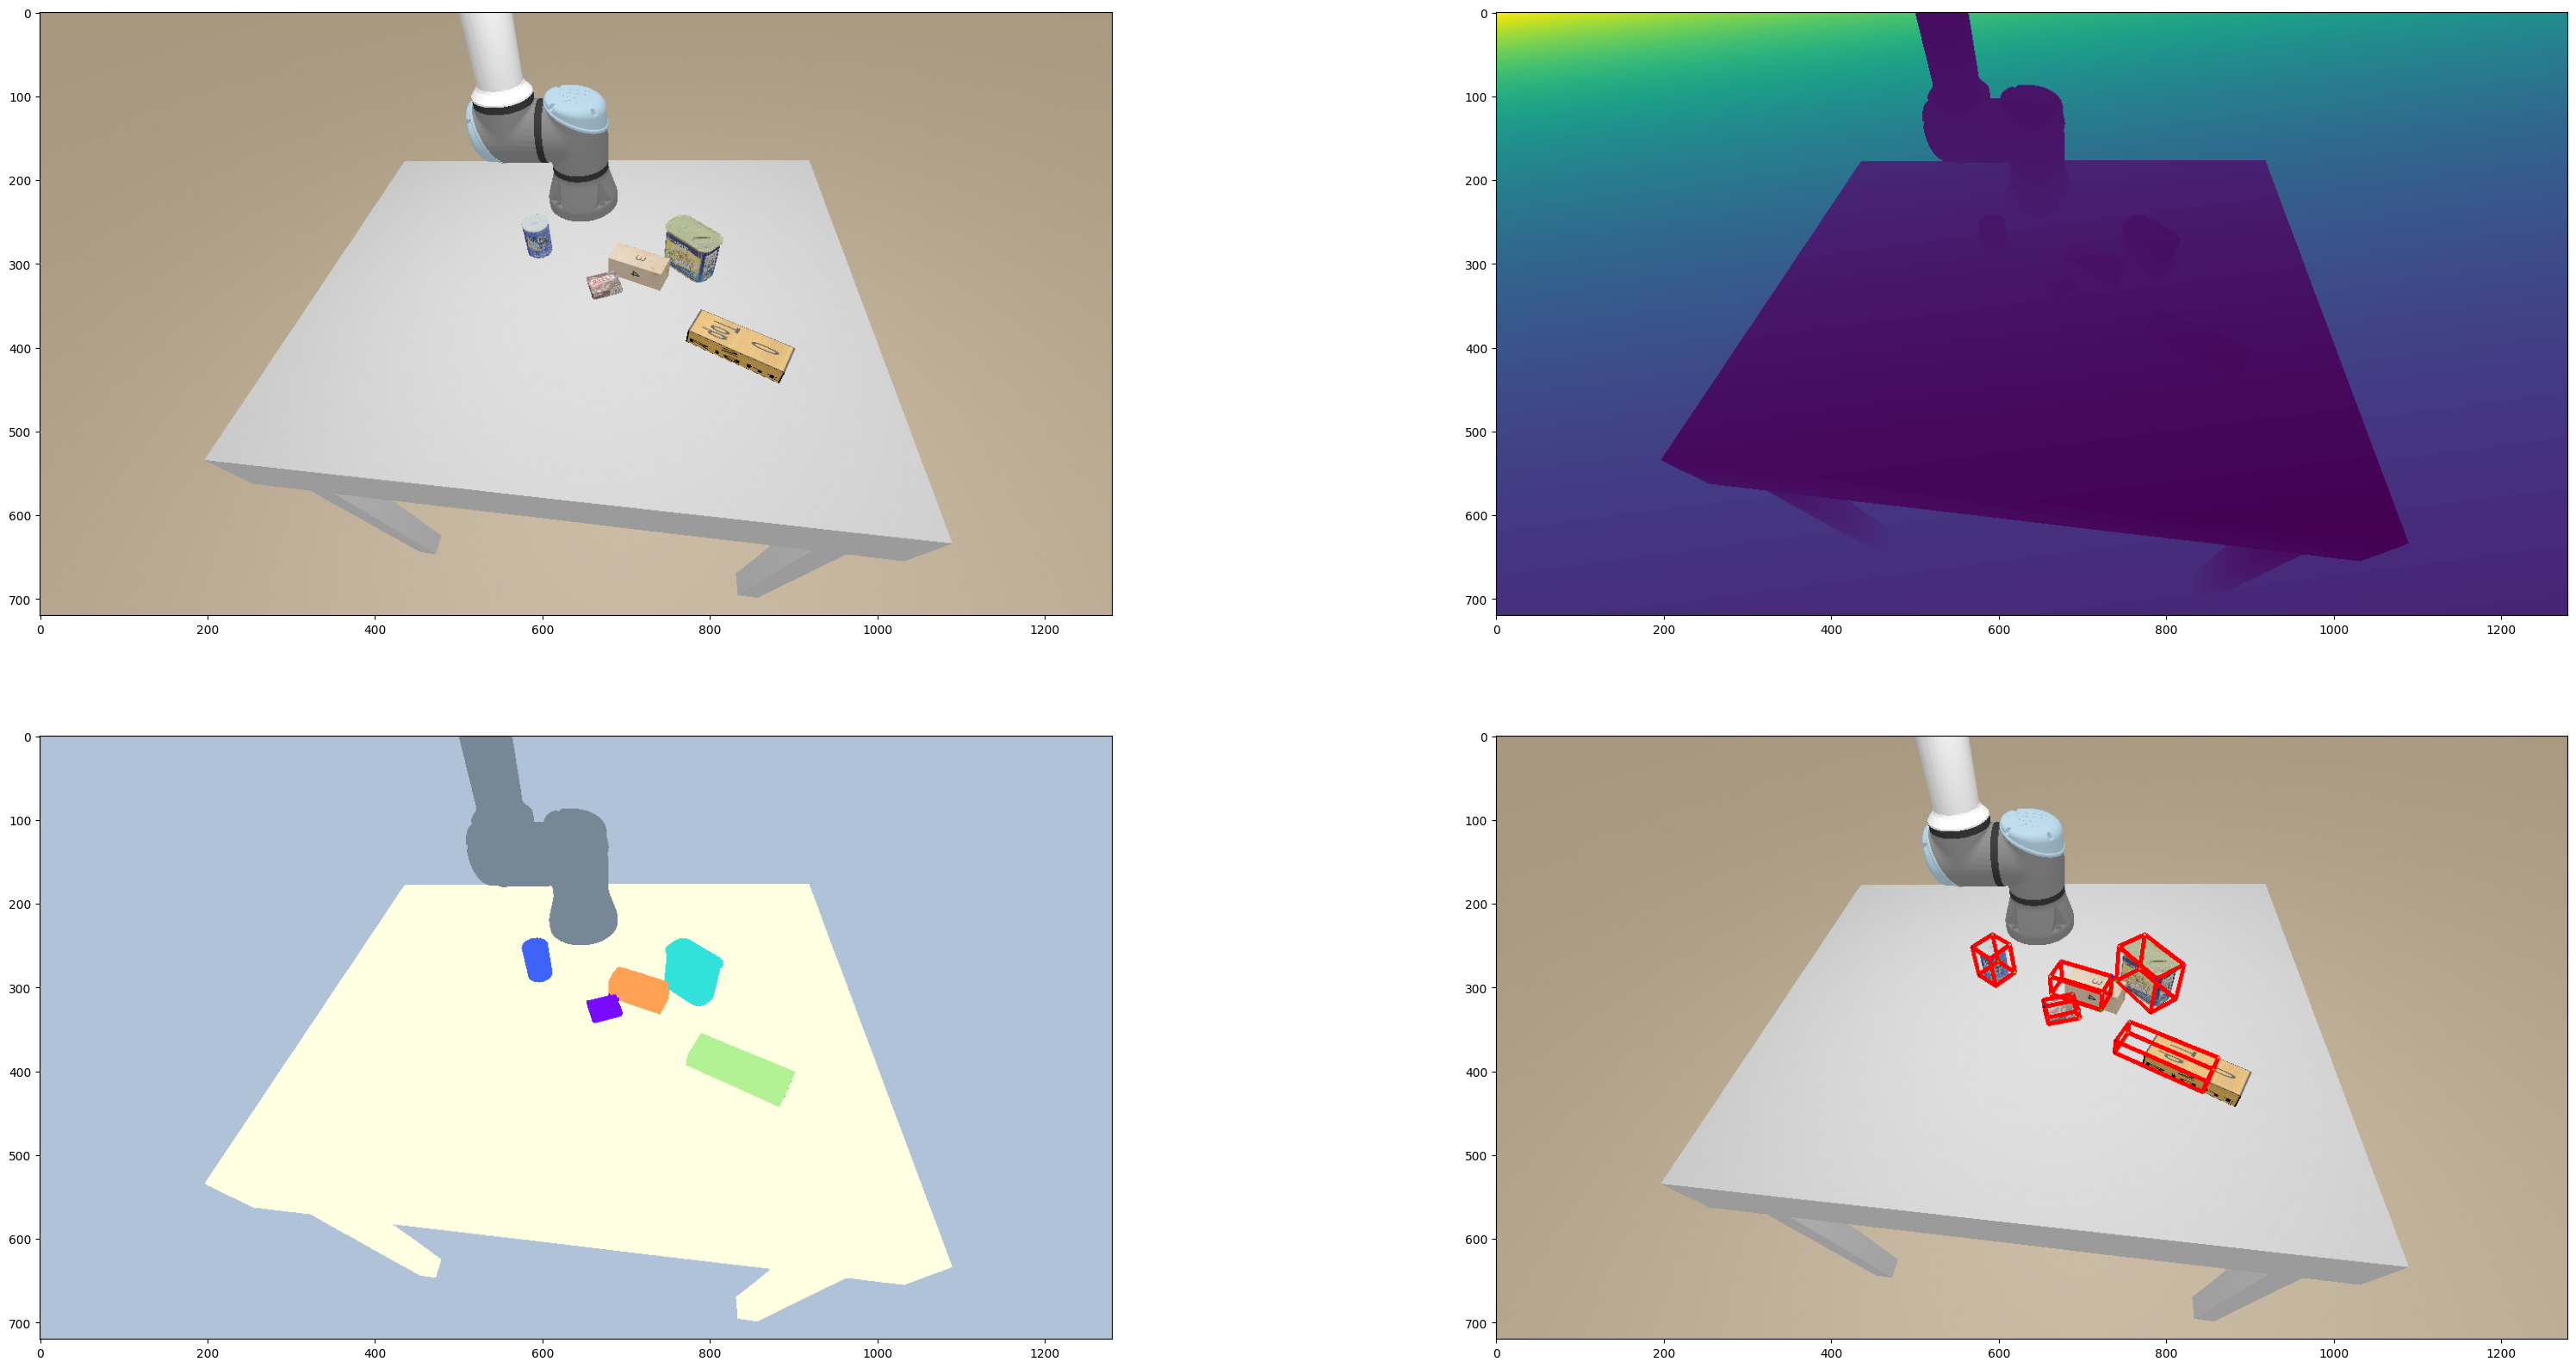

In [3]:
from utils.utils_data import *
import pickle
from datetime import datetime
from benchmark_utils.benchmark import *

now = datetime.now().strftime("%d-%H:%M")
fname = f'./exp_icp/test_icpo3d_{now}'

''' 1. Load object legos and poses '''
with open('./training_data/lego_poses.pickle', 'rb') as handle:
    OBJ_LEGO = pickle.load(handle)

''' 2. ICP !!! '''
# file_dict = get_split_files('val_tiny')
file_dict = get_test_files('./testing_data_2')
rgb, depth, label, meta, scene = file_dict['rgb_files'], file_dict['depth_files'], \
    file_dict['label_files'], file_dict['meta_files'], file_dict['suffixes']


vis_k = 0  # Visualize k-th scene result
preds = {}
with tqdm(total=len(rgb)) as pbar:
    for i,(_rgb, _depth, _label, _meta, _scene) in \
    enumerate(zip(rgb, depth, label, meta, scene)):

        if i < vis_k: continue
        if i > vis_k: break

        r, d, l, m = load_files(_rgb, _depth, _label, _meta)
        
        poses_world = icp_one_scene_lego(OBJ_LEGO, r, d, l, m, icp_thresh=1e-4)
        preds[_scene] = {"poses_world": poses_world}
        
        append_preds(preds, name=fname)
        pbar.update(1)

        ''' ---- See results --- '''
        m['poses_world'] = poses_world
        visualize_training_data(r, d, l, m)

[['14' 'cracker_box']
 ['48' 'potted_meat_can']
 ['55' 'sugar_box']
 ['56' 'tomato_soup_can']
 ['58' 'wood_block']] Scene: None


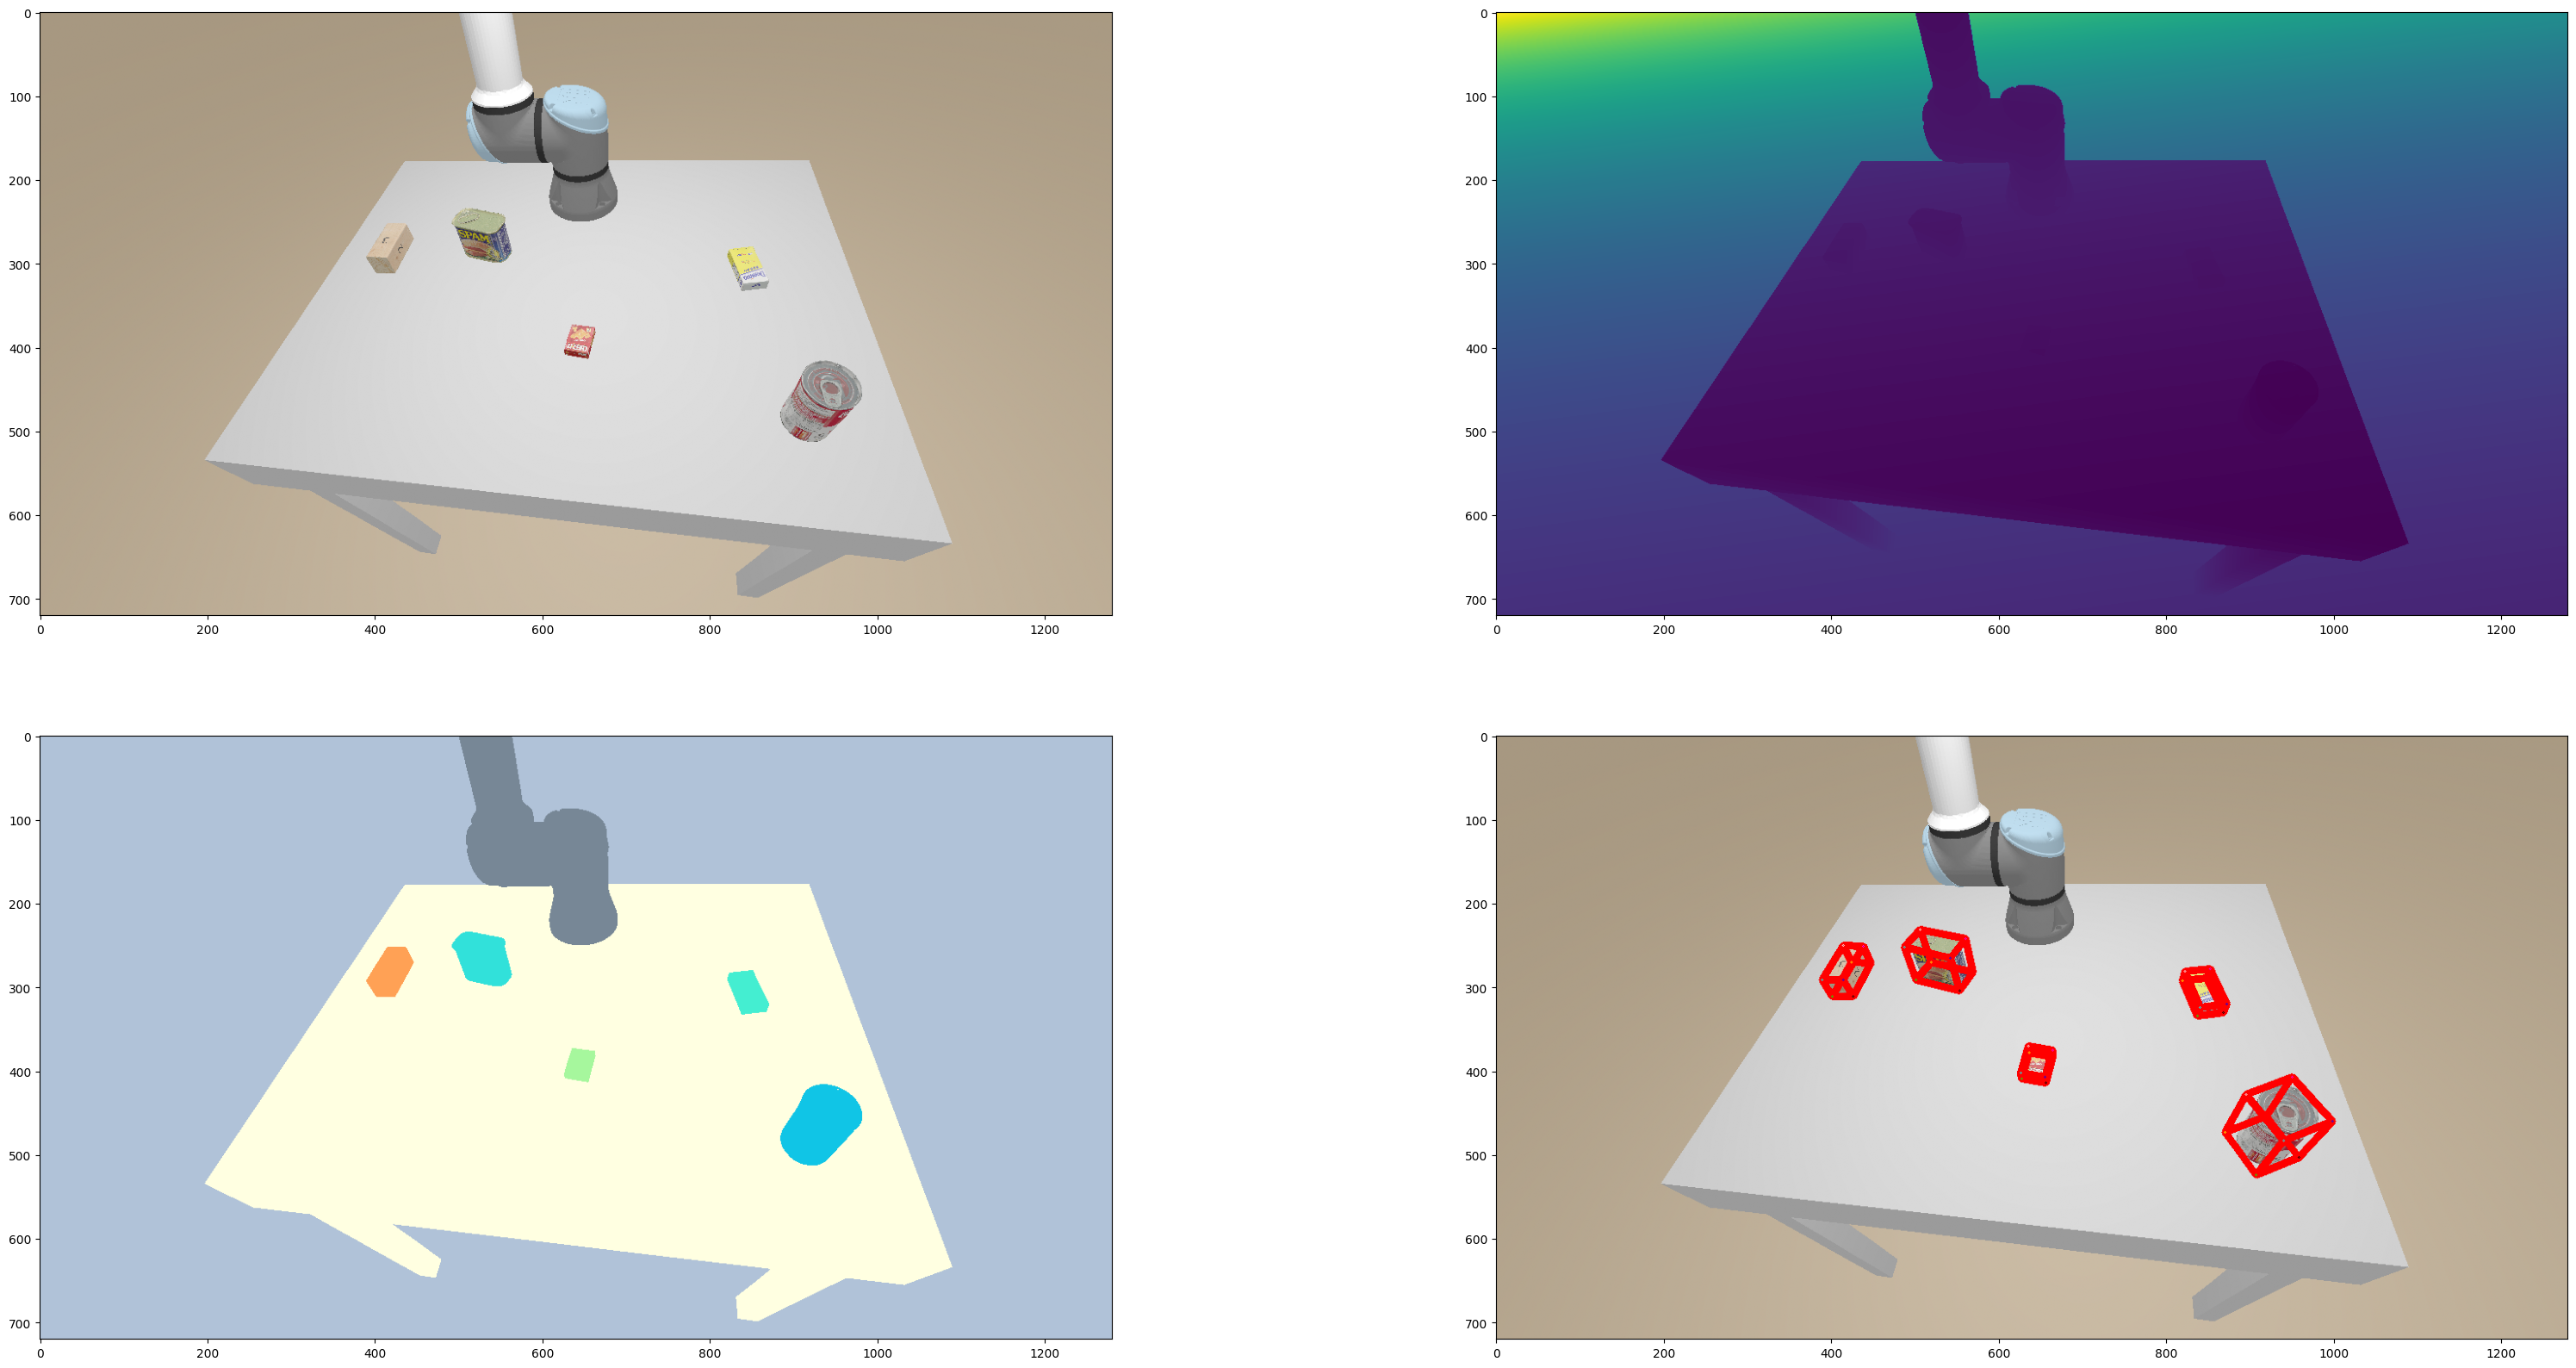

In [6]:
# gt_path = "./training_data/val_gt_tiny.json"
gt_path = "./training_data/val_gt_tiny.json"
pred_path = f'{fname}.json'
val_gt_json = json.load(open(gt_path, "r"))
val_pred_json = json.load(open(pred_path, "r"))
eval_result, err_dict_all, headers, table = evaluate(val_gt_json, val_pred_json, level_ids=[1, 2])

print(eval_result)


m['poses_world'] = poses_world
visualize_training_data(r, d, l, m)